# Description

Runs VAE with standard parameters. It saves the model and generates plots.

# Modules

In [41]:
# reload imported modules if changed
%load_ext autoreload
%autoreload 2

import pprint

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pyreadr
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from pvae import conf
from pvae.data import FeatherDataset
from pvae.models import VariationalAutoencoder
from pvae.models_utils import train_vae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Settings and paths

In [42]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
display(DEVICE)

'cuda'

In [43]:
# Model parameters
K = 782
KL_L = 1.0
PRED_L = 2.0

# Others parameters
K_FOLDS = 3
N_FOLDS_TO_RUN = None  # None to run all K_FOLDS (used for testing)
N_EPOCS = 50
BATCH_SIZE = 50
PATHWAYS_TRAINING_PERC = 0.80
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0
RANDOM_SEED = 0

In [44]:
# Paths
OUTPUT_FOLDER = (
    conf.data.OUTPUT_DIR
    / "models"
    / "mice_vae"
    / f"k_{K}-kl_l_{KL_L}-pred_l_{PRED_L}-batch_size_{BATCH_SIZE}-lr_{LEARNING_RATE:.0e}-n_epochs_{N_EPOCS}"
)
VAE_MODEL_OUTPUT_FILE = "fold_{fold}-mice_vae_model.pt"
DATA_SCALER_OUTPUT_FILE = "fold_{fold}-data_scaler.joblib"

In [45]:
# INPUT_FILES and OUTPUT_FILES must be provided if running with pytask
INPUT_FILES = {
    "mice_gene_expr_data_input": conf.data.MICE_PROCESSED_DIR
    / "mice_data-full-log.ftr",
    "mice_plier_model_Z": conf.data.MICE_PROCESSED_DIR
    / "mice_model_Z_std.csv",
    "mice_plier_model_B": conf.data.MICE_PROCESSED_DIR
    / "mice_model_B_std.csv"}

OUTPUT_FILES = {
    f"mice_vae_model_fold{i}": OUTPUT_FOLDER / VAE_MODEL_OUTPUT_FILE.format(fold=i)
    for i in range(min(K_FOLDS, N_FOLDS_TO_RUN or K_FOLDS))
}
OUTPUT_FILES.update(
    {
        f"data_scaler_fold{i}": OUTPUT_FOLDER / DATA_SCALER_OUTPUT_FILE.format(fold=i)
        for i in range(min(K_FOLDS, N_FOLDS_TO_RUN or K_FOLDS))
    }
)
OUTPUT_FILES.update({"performance_stats": OUTPUT_FOLDER / "performance_stats.pkl"})

In [46]:
pprint.pprint(INPUT_FILES)

{'mice_gene_expr_data_input': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_data-full-log.ftr'),
 'mice_plier_model_B': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_model_B_std.csv'),
 'mice_plier_model_Z': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_model_Z_std.csv')}


In [47]:
pprint.pprint(OUTPUT_FILES)

{'data_scaler_fold0': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_782-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_0-data_scaler.joblib'),
 'data_scaler_fold1': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_782-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_1-data_scaler.joblib'),
 'data_scaler_fold2': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_782-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_2-data_scaler.joblib'),
 'mice_vae_model_fold0': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_782-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_0-mice_vae_model.pt'),
 'mice_vae_model_fold1': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_782-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_1-mice_vae_model.pt'),
 'mice_vae_model_fold2': PosixPath('

In [48]:
for _k, v in OUTPUT_FILES.items():
    v.parent.mkdir(parents=True, exist_ok=True)

# Load data

## FeatherDataset

In [49]:
dataset = FeatherDataset(INPUT_FILES["mice_gene_expr_data_input"], read_full_data=True)
# temp = torch.nan_to_num(dataset[:][0], nan=0.0)
# print(temp)
# print(torch.any(torch.isnan(temp)))

In [50]:
dataset[:][0][torch.isnan(dataset[:][0])] = 0
dataset.data.shape
nan_mask = torch.isnan(dataset[:][0])
has_nan = torch.any(nan_mask)
print(nan_mask)
print(has_nan)
nan_indices = torch.nonzero(nan_mask)
print(nan_indices)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor(False)
tensor([], size=(0, 2), dtype=torch.int64)


In [51]:
display(dataset.length)
assert dataset.length == 190110

190110

In [52]:
dataset[0]

(tensor([1.4206, 1.4944, 3.2461,  ..., 1.3528, 1.5780, 1.3453]), tensor([]), 0)

## Get dataset dimensions

In [53]:
data_n_samples = dataset.length
display(data_n_samples)

data_n_genes = dataset[0][0].shape[0]
display(data_n_genes)

190110

10849

## Samples and their tissues

In [54]:
sample_tissues = pd.read_pickle(INPUT_FILES["gtex_samples_metadata"])

KeyError: 'gtex_samples_metadata'

In [ ]:
# sample_tissues

## Prior knowledge / pathways

In [ ]:
pathways = pd.read_pickle(INPUT_FILES["pathways"])

In [ ]:
pathways.shape

In [ ]:
pathways.head()

In [ ]:
pathways.apply(sum).sort_values()

In [ ]:
n_pathways = pathways.shape[1]
display(n_pathways)

# VAE

In [60]:
random_state = np.random.RandomState(RANDOM_SEED)

In [61]:
def create_model():
    return VariationalAutoencoder(
        k=K,
        n_features=data_n_genes,
        n_samples=data_n_samples,
        n_pathways=0,
        kl_l=KL_L,
        pred_l=PRED_L,
    )

In [62]:
display(create_model())

/home/prashant/miniconda3/envs/pvae/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=10849, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (mu_layer): Linear(in_features=512, out_features=782, bias=True)
    (sigma_layer): Linear(in_features=512, out_features=782, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=782, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_recon): Linear(in_features=512, out_features=10849, bias=True)
  )
  (predictor): PathwaysPredictor(
    (pathway_prediction): Sequential(
      (0): Linear(in_features=190110, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=0, bias=True)
  

In [72]:
folds_train_losses, folds_val_losses = train_vae(
    create_model,
    dataset,
    pathways=np.zeros((0, 0)),
    pathways_training_perc=PATHWAYS_TRAINING_PERC,
    models_output_dir=OUTPUT_FOLDER,
    vae_output_file_template=VAE_MODEL_OUTPUT_FILE,
    scaler_output_files_template=DATA_SCALER_OUTPUT_FILE,
    k_folds=K_FOLDS,
    n_folds_to_run=N_FOLDS_TO_RUN,
    epochs=N_EPOCS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    wd=WEIGHT_DECAY,
    random_state=random_state,
)

Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: 6,039 / 4,634 =	5,415 / 4,081 +	624 / 553 
Epoch 1: 4,755 / 4,184 =	4,144 / 3,618 +	611 / 566 
Epoch 2: 4,437 / 3,930 =	3,823 / 3,357 +	614 / 573 
Epoch 3: 4,248 / 3,756 =	3,630 / 3,176 +	618 / 580 
Epoch 4: 4,120 / 3,646 =	3,501 / 3,066 +	619 / 580 
Epoch 5: 4,026 / 3,555 =	3,409 / 2,974 +	617 / 581 
Epoch 6: 3,955 / 3,483 =	3,340 / 2,906 +	615 / 577 
Epoch 7: 3,894 / 3,415 =	3,284 / 2,840 +	610 / 575 
Epoch 8: 3,843 / 3,374 =	3,237 / 2,803 +	606 / 571 
Epoch 9: 3,794 / 3,314 =	3,193 / 2,746 +	600 / 567 
Epoch 10: 3,751 / 3,276 =	3,156 / 2,712 +	595 / 564 
Epoch 11: 3,710 / 3,227 =	3,121 / 2,667 +	589 / 560 
Epoch 12: 3,673 / 3,189 =	3,090 / 2,635 +	583 / 554 
Epoch 13: 3,638 / 3,165 =	3,061 / 2,612 +	577 / 552 
Epoch 14: 3,606 / 3,118 =	3,035 / 2,574 +	571 / 545 
Epoch 15: 3,576 / 3,090 =	3,011 / 2,550 +	565 / 540 
Epoch 16: 3,548 / 3,070 =	2,988 / 2,534 +	560 / 535 
Epoch 17: 3,521 / 3,043 =	2,966 / 2,512 +	556 / 531 
Epoch 18: 3,501 / 3,025 =	2,949 / 2,497 +	552 / 528 
Epo

/home/prashant/miniconda3/envs/pvae/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: 6,044 / 4,684 =	5,411 / 4,129 +	632 / 555 
Epoch 1: 4,753 / 4,222 =	4,141 / 3,654 +	613 / 568 
Epoch 2: 4,436 / 3,955 =	3,821 / 3,376 +	615 / 579 
Epoch 3: 4,249 / 3,788 =	3,630 / 3,211 +	618 / 578 
Epoch 4: 4,126 / 3,664 =	3,506 / 3,077 +	619 / 587 
Epoch 5: 4,026 / 3,579 =	3,409 / 2,992 +	617 / 586 
Epoch 6: 3,955 / 3,497 =	3,340 / 2,908 +	615 / 589 
Epoch 7: 3,896 / 3,441 =	3,285 / 2,866 +	611 / 575 
Epoch 8: 3,841 / 3,382 =	3,235 / 2,807 +	606 / 575 
Epoch 9: 3,796 / 3,326 =	3,196 / 2,753 +	601 / 573 
Epoch 10: 3,747 / 3,288 =	3,153 / 2,721 +	594 / 567 
Epoch 11: 3,707 / 3,241 =	3,119 / 2,679 +	588 / 562 
Epoch 12: 3,671 / 3,201 =	3,089 / 2,645 +	582 / 555 
Epoch 13: 3,633 / 3,173 =	3,057 / 2,622 +	576 / 550 
Epoch 14: 3,600 / 3,131 =	3,031 / 2,582 +	569 / 549 
Epoch 15: 3,571 / 3,101 =	3,007 / 2,559 +	564 / 542 
Epoch 16: 3,544 / 3,072 =	2,985 / 2,533 +	559 / 539 
Epoch 17: 3,520 / 3,050 =	2,965 / 2,513 +	555 / 537 
Epoch 18: 3,496 / 3,028 =	2,945 / 2,494 +	551 / 534 
Epo

/home/prashant/miniconda3/envs/pvae/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: 6,043 / 4,663 =	5,416 / 4,103 +	627 / 559 
Epoch 1: 4,758 / 4,199 =	4,147 / 3,637 +	611 / 562 
Epoch 2: 4,438 / 3,951 =	3,823 / 3,376 +	615 / 574 
Epoch 3: 4,251 / 3,779 =	3,633 / 3,204 +	618 / 576 
Epoch 4: 4,124 / 3,649 =	3,506 / 3,065 +	619 / 584 
Epoch 5: 4,034 / 3,566 =	3,416 / 2,981 +	618 / 585 
Epoch 6: 3,959 / 3,496 =	3,344 / 2,916 +	615 / 580 
Epoch 7: 3,899 / 3,427 =	3,288 / 2,851 +	611 / 577 
Epoch 8: 3,847 / 3,368 =	3,240 / 2,791 +	606 / 578 
Epoch 9: 3,797 / 3,328 =	3,195 / 2,760 +	601 / 568 
Epoch 10: 3,753 / 3,284 =	3,158 / 2,718 +	595 / 566 
Epoch 11: 3,715 / 3,244 =	3,126 / 2,687 +	589 / 557 
Epoch 12: 3,674 / 3,198 =	3,092 / 2,644 +	582 / 554 
Epoch 13: 3,642 / 3,156 =	3,066 / 2,606 +	576 / 550 
Epoch 14: 3,608 / 3,128 =	3,038 / 2,580 +	570 / 547 
Epoch 15: 3,576 / 3,093 =	3,012 / 2,552 +	564 / 541 
Epoch 16: 3,549 / 3,069 =	2,991 / 2,532 +	559 / 537 
Epoch 17: 3,522 / 3,038 =	2,968 / 2,506 +	554 / 532 
Epoch 18: 3,500 / 3,021 =	2,951 / 2,491 +	550 / 530 
Epo

# Average performance across folds

## Prepare

In [73]:
df_perf = []

for fold in range(len(folds_train_losses)):
    fold_perf = folds_train_losses[fold]
    df_train = pd.DataFrame(dict(fold_perf.items()))
    df_train = df_train.assign(fold=fold, mode="train")
    df_train = df_train.reset_index().rename(columns={"index": "epoch"})
    df_train = df_train.set_index(["mode", "fold", "epoch"]).rename_axis(columns="perf")

    fold_perf = folds_val_losses[fold]
    df_val = pd.DataFrame(dict(fold_perf.items()))
    df_val = df_val.assign(fold=fold, mode="val")
    df_val = df_val.reset_index().rename(columns={"index": "epoch"})
    df_val = df_val.set_index(["mode", "fold", "epoch"]).rename_axis(columns="perf")

    df_all = pd.concat([df_train, df_val], axis=0)

    df_perf.append(df_all)

In [74]:
df_perf = pd.concat(df_perf)

In [75]:
df_perf.shape

(300, 3)

In [76]:
df_perf.head()

perf                     full          mse          kl
mode  fold epoch                                      
train 0    0      6038.513641  5414.881518  623.632119
           1      4754.531277  4143.639415  610.891861
           2      4437.129540  3822.797980  614.331563
           3      4247.950440  3629.674448  618.275992
           4      4119.861749  3500.953807  618.907941

## Stats

In [77]:
df_perf.loc["train"].describe()

perf,full,mse,kl
count,150.000000,150.000000,150.000000
mean,3586.471038,3032.602550,553.868488
std,478.422940,450.276090,35.150622
min,3271.234087,2748.338841,521.199029
25%,3314.166981,2788.097056,526.026493
50%,3400.871770,2866.093514,534.674876
75%,3672.337021,3089.676265,582.104569
max,6043.608715,5415.746735,632.473561


In [78]:
df_perf.loc["val"].describe()

perf,full,mse,kl
count,150.000000,150.000000,150.000000
mean,3084.212327,2550.664552,533.547776
std,394.999163,375.498888,24.533925
min,2771.857132,2259.481988,508.279225
25%,2824.295410,2309.536081,514.758477
50%,2917.408321,2395.525989,521.274717
75%,3195.574677,2641.678616,553.404392
max,4684.067044,4129.470405,589.151496


### Save

In [79]:
df_perf.to_pickle(OUTPUT_FILES["performance_stats"])

## Plots

In [80]:
df_plot = df_perf.stack().rename("value").reset_index()

In [81]:
df_plot

,mode,fold,epoch,perf,value
0,train,0,0,full,6038.513641
1,train,0,0,mse,5414.881518
2,train,0,0,kl,623.632119
3,train,0,1,full,4754.531277
4,train,0,1,mse,4143.639415
...,...,...,...,...,...
895,val,2,48,mse,2272.082828
896,val,2,48,kl,508.563911
897,val,2,49,full,2777.109855
898,val,2,49,mse,2265.074988


In [82]:
df_plot = df_plot.astype(
    {
        "perf": "category",
        "mode": "category",
    }
)

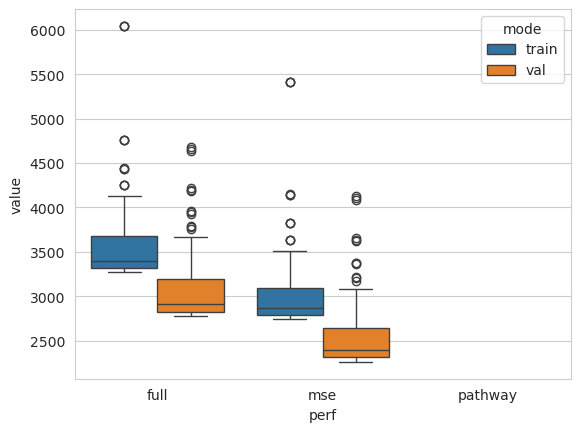

In [83]:
with sns.axes_style("whitegrid"):
    sns.boxplot(
        data=df_plot, x="perf", y="value", hue="mode", order=["full", "mse", "pathway"]
    )

# Learning curves

In [55]:
train_losses = folds_train_losses[0]
val_losses = folds_val_losses[0]

NameError: name 'folds_train_losses' is not defined

In [85]:
train_losses.keys()

dict_keys(['full', 'mse', 'kl'])

In [86]:
val_losses.keys()

dict_keys(['full', 'mse', 'kl'])

## Combined: MSE and pathway

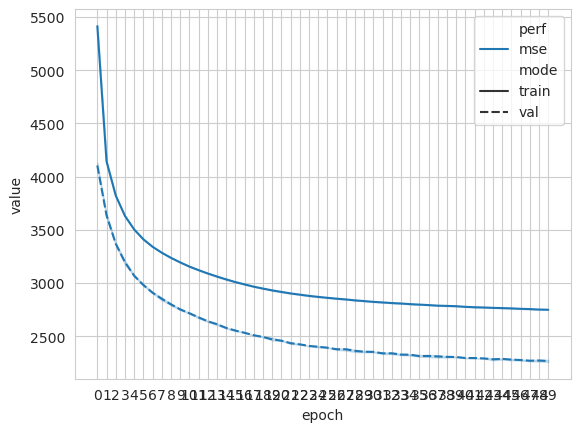

In [87]:
with sns.axes_style("whitegrid"):  # , sns.color_palette("Paired"):
    ax = sns.lineplot(
        data=df_plot,
        x="epoch",
        y="value",
        hue="perf",
        hue_order=["mse"],
        style="mode",
    )
    ax.set_xticks(df_plot["epoch"].unique())

## Full loss

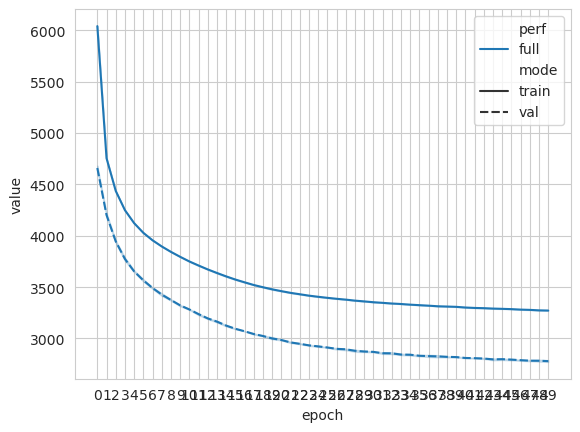

In [88]:
with sns.axes_style("whitegrid"):  # , sns.color_palette("Paired"):
    ax = sns.lineplot(
        data=df_plot, x="epoch", y="value", hue="perf", hue_order=["full"], style="mode"
    )
    ax.set_xticks(df_plot["epoch"].unique())

## MSE loss

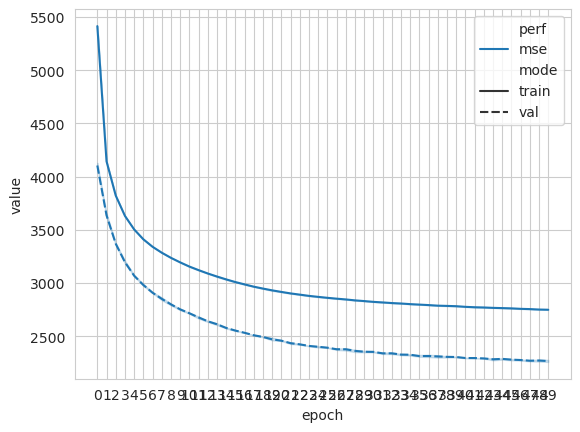

In [89]:
with sns.axes_style("whitegrid"):  # , sns.color_palette("Paired"):
    ax = sns.lineplot(
        data=df_plot, x="epoch", y="value", hue="perf", hue_order=["mse"], style="mode"
    )
    ax.set_xticks(df_plot["epoch"].unique())

## KL loss

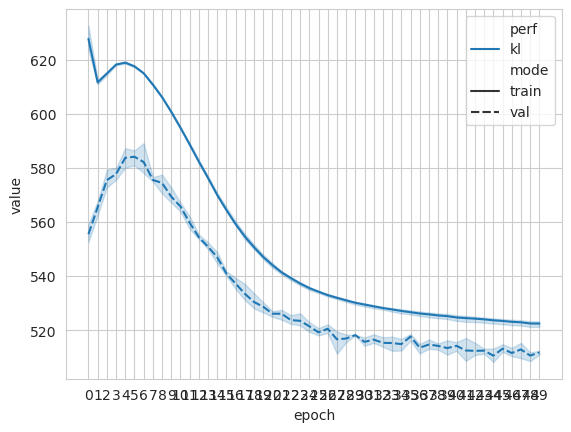

In [90]:
with sns.axes_style("whitegrid"):  # , sns.color_palette("Paired"):
    ax = sns.lineplot(
        data=df_plot, x="epoch", y="value", hue="perf", hue_order=["kl"], style="mode"
    )
    ax.set_xticks(df_plot["epoch"].unique())

## Pathway prediction loss

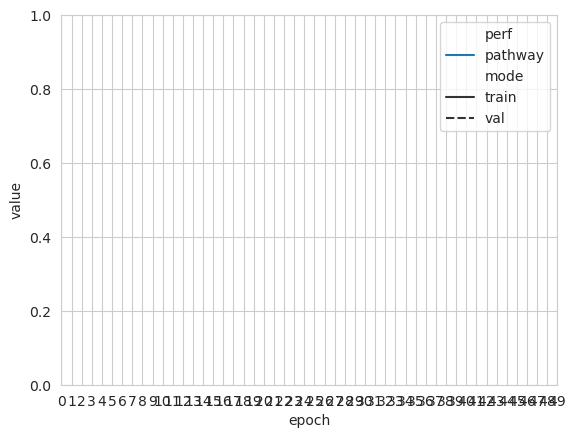

In [91]:
with sns.axes_style("whitegrid"):  # , sns.color_palette("Paired"):
    ax = sns.lineplot(
        data=df_plot,
        x="epoch",
        y="value",
        hue="perf",
        hue_order=["pathway"],
        style="mode",
    )
    ax.set_xticks(df_plot["epoch"].unique())

# Load a model

In [63]:
_fold = 0

In [64]:
train_data_scaler = joblib.load(OUTPUT_FILES[f"data_scaler_fold{_fold}"])
display(train_data_scaler)

StandardScaler()

In [65]:
model = create_model()
model.load_state_dict(torch.load(OUTPUT_FILES[f"mice_vae_model_fold{_fold}"]))
model.to("cpu")
model.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=10849, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (mu_layer): Linear(in_features=512, out_features=782, bias=True)
    (sigma_layer): Linear(in_features=512, out_features=782, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=782, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_recon): Linear(in_features=512, out_features=10849, bias=True)
  )
  (predictor): PathwaysPredictor(
    (pathway_prediction): Sequential(
      (0): Linear(in_features=190110, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=0, bias=True)
  

# Save

In [66]:
data = pd.read_feather(INPUT_FILES["mice_gene_expr_data_input"]).set_index("index")

In [67]:
orig_data = torch.as_tensor(
    train_data_scaler.transform(data.T.to_numpy()), dtype=torch.float32
).detach()

In [68]:
orig_data.shape

torch.Size([190110, 10849])

## Latent space

In [99]:
z = model.encoder(orig_data).detach().numpy()

In [100]:
z.shape

(190110, 782)

In [101]:
z = pd.DataFrame(
    data=z, index=data.columns.tolist(), columns=[f"lv{i}" for i in range(K)]
)

In [102]:
z.head()

,lv0,lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9,...,lv772,lv773,lv774,lv775,lv776,lv777,lv778,lv779,lv780,lv781
SRR1557113,1.103322,0.387241,-0.013177,-0.196332,0.609018,0.736991,-0.069995,-0.318127,0.167848,0.162448,...,0.166642,-0.065707,0.804196,-0.256528,-0.597899,0.150306,-0.377947,0.233392,-0.699747,-0.016084
SRR1557114,0.492810,-0.530430,0.191335,0.543094,0.049119,0.102342,-0.600430,1.106902,0.301367,0.244489,...,0.055177,1.308863,1.561180,0.717529,0.439479,-0.061546,-0.197601,-1.115380,-0.007963,0.373927
SRR1557115,0.831623,-0.134697,0.072116,0.788732,-0.384351,0.110733,1.225762,-0.773736,0.163123,0.917118,...,-0.588133,-0.186060,0.001157,0.201172,0.180235,1.805565,-0.640540,0.420413,-0.296352,0.761392
SRR1557116,1.761768,1.021889,0.302441,0.651107,0.423690,-0.427824,-0.485930,0.305338,0.196228,1.328221,...,-0.080264,-0.112621,0.751405,1.485577,0.044972,-0.615389,0.158413,0.197265,0.806728,0.424432
SRR1557117,0.078769,-0.505511,-0.024110,1.204406,1.690005,-0.867380,0.075786,-0.382332,0.292774,-0.841274,...,0.042284,0.480720,0.468656,1.084906,0.086640,-1.222102,-0.967442,-0.939019,-0.690443,-0.224735


In [103]:
# z.to_pickle(OUTPUT_FILES["pvae_latent_space"])

## Reconstructed data

In [104]:
data_recon = model.forward(orig_data).detach()

In [105]:
data_recon.shape

torch.Size([190110, 10849])

In [106]:
data_recon

tensor([[-0.1903,  0.0703,  4.5690,  ..., -1.7637, -0.1744, -0.4659],
        [-0.4166, -0.2210,  2.8356,  ..., -1.2497, -0.8946, -0.1865],
        [-0.2203, -0.0233,  3.3223,  ..., -1.4500, -0.6078, -0.2889],
        ...,
        [-0.1934, -0.5730,  0.9420,  ...,  1.1587,  0.2124,  0.1310],
        [-0.2640, -0.6504,  1.1634,  ...,  1.0327,  0.2026,  0.2728],
        [-0.3111, -0.4272,  1.1180,  ...,  1.1824,  0.1856,  0.2018]])

In [107]:
data_recon_df = pd.DataFrame(
    data=data_recon.T.detach().numpy(),
    index=data.index.tolist(),
    columns=data.columns.tolist(),
)

In [108]:
data_recon_df.shape

(10849, 190110)

In [109]:
data_recon_df.head()

,SRR1557113,SRR1557114,SRR1557115,SRR1557116,SRR1557117,SRR1557118,SRR1557119,SRR1557120,SRR1557121,SRR1557122,...,ERR1082767,ERR1082768,ERR1082769,ERR1082770,SRR5445512,SRR5445513,SRR5445514,SRR5445515,SRR5445516,SRR5445517
Xkr4,-0.190278,-0.416579,-0.220289,-0.081798,0.297320,0.400552,0.389717,0.676734,0.663680,0.583094,...,0.866577,0.780025,0.463210,0.536930,-0.481403,-0.482096,-0.400534,-0.193393,-0.264037,-0.311082
Sox17,0.070291,-0.221048,-0.023328,1.170926,-0.558805,0.402898,0.291500,0.186136,-0.449499,-0.406151,...,0.090087,-0.137341,-0.023347,0.110840,-0.732053,-0.695407,-0.836203,-0.572988,-0.650374,-0.427153
Mrpl15,4.569022,2.835599,3.322265,2.580468,-0.499607,0.699598,0.215585,1.687833,0.202589,0.939854,...,-0.705457,-0.771416,-0.744898,-0.719939,1.360240,1.547926,1.444453,0.941995,1.163429,1.117992
Lypla1,2.898445,2.010186,2.460401,2.219071,-0.127294,0.669099,0.104600,1.121601,0.148729,0.475158,...,-0.036861,-0.146423,-0.111917,-0.249507,1.192581,1.296981,1.306166,0.670451,0.885429,0.815348
Tcea1,3.801979,2.411497,3.219164,2.635842,0.225515,1.018724,0.595856,2.056087,0.691649,1.394968,...,0.423140,0.356196,0.460775,0.253744,1.439495,1.481123,1.774122,0.681649,0.844888,0.630213


In [110]:
# data_recon_df.to_pickle(OUTPUT_FILES["pvae_data_recon"])

# MSE

In [111]:
_l = nn.MSELoss()
display(_l(data_recon, orig_data))

tensor(0.2061)

In [112]:
_l = nn.MSELoss(reduction="sum")
display(_l(data_recon, orig_data))

tensor(4.2517e+08)

# Plot

In [113]:
scaler = StandardScaler().set_output(transform="pandas")
z_scaled = scaler.fit_transform(z)

In [114]:
z_scaled.head()

,lv0,lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9,...,lv772,lv773,lv774,lv775,lv776,lv777,lv778,lv779,lv780,lv781
SRR1557113,1.330963,0.557963,-0.018510,-0.282848,0.873289,1.060758,-0.101295,-0.467253,0.236930,0.234833,...,0.236716,-0.100126,1.129715,-0.368312,-0.841773,0.219419,-0.499477,0.335416,-1.004132,-0.025715
SRR1557114,0.553051,-0.758699,0.278529,0.765585,0.070714,0.146374,-0.857501,1.626923,0.426768,0.351432,...,0.075942,1.870115,2.195577,1.022949,0.624351,-0.080903,-0.247527,-1.601446,-0.010783,0.551166
SRR1557115,0.984765,-0.190907,0.105373,1.113875,-0.550635,0.158463,1.745976,-1.136802,0.230212,1.307382,...,-0.851954,-0.272636,-0.000994,0.285427,0.257962,2.565913,-0.866328,0.603982,-0.424888,1.124282
SRR1557116,2.169952,1.468548,0.439903,0.918736,0.607634,-0.617473,-0.694266,0.448970,0.277282,1.891647,...,-0.119416,-0.167371,1.055383,2.119965,0.066796,-0.866030,0.249837,0.283537,1.159052,0.625869
SRR1557117,0.025482,-0.722946,-0.034389,1.703259,2.422805,-1.250774,0.106535,-0.561607,0.414551,-1.191671,...,0.057344,0.683094,0.657262,1.547679,0.125684,-1.726105,-1.323023,-1.348189,-0.990772,-0.334339


## Latent space

### PCA

In [115]:
pca = PCA(n_components=4, random_state=0).set_output(transform="pandas")
z_pca = pca.fit_transform(z_scaled)

In [116]:
z_pca.shape

(190110, 4)

In [120]:
z_pca.head()

,pca0,pca1,pca2,pca3
SRR1557113,2.659878,2.449612,-0.618608,-1.122522
SRR1557114,2.948309,3.026635,-0.373138,-1.067020
SRR1557115,3.100424,2.494738,-0.183722,-0.588558
SRR1557116,2.843587,3.480740,0.123096,-0.622669
SRR1557117,3.679893,2.263857,0.274449,-2.200336


In [121]:
# df_plot = z_pca.assign(tissue=sample_tissues["simplified_tissue"])

In [122]:
# df_plot

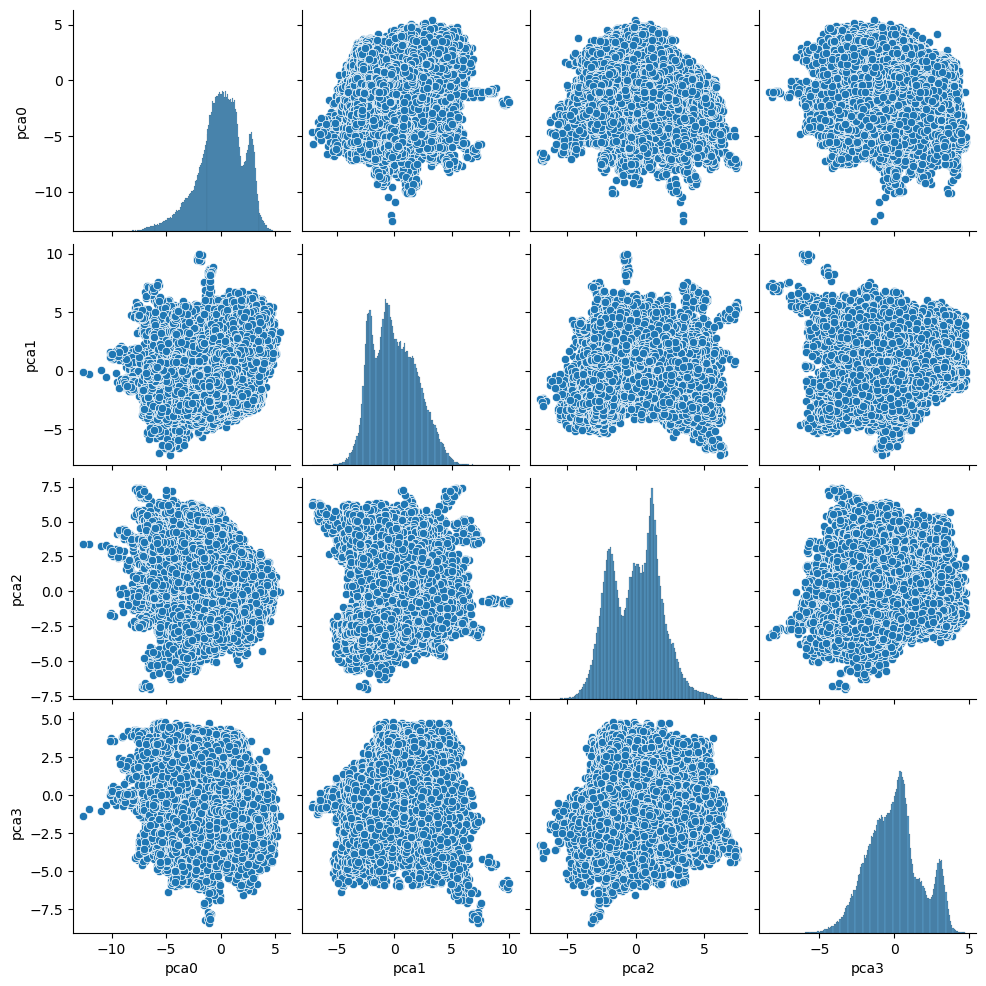

In [124]:
# sns.set_theme(style="ticks", palette="tab10")
sns.pairplot(data=z_pca)

# PLIER B Matrix (Mice)

In [29]:
df_B = pd.read_csv(INPUT_FILES['mice_plier_model_B'])
df_B = df_B.set_index("Unnamed: 0").rename_axis(index=None)
df_B = df_B.drop('SRR1557112', axis=1)
df_B.head()

,SRR1557113,SRR1557114,SRR1557115,SRR1557116,SRR1557117,SRR1557118,SRR1557119,SRR1557120,SRR1557121,SRR1557122,...,ERR1082767,ERR1082768,ERR1082769,ERR1082770,SRR5445512,SRR5445513,SRR5445514,SRR5445515,SRR5445516,SRR5445517
LV1,-0.268300,-0.670830,-0.345494,-0.342450,-0.243202,-0.441225,-0.485892,-0.392068,-0.590909,-0.417210,...,-0.304969,-0.319332,-0.317460,-0.369937,-0.429210,-0.419838,-0.447235,-0.182112,-0.192730,-0.186131
LV2,6.929067,6.082590,7.217676,6.832574,5.376394,3.370360,2.939453,4.769698,1.928760,3.046538,...,-0.693722,-0.669089,-0.688071,-0.789017,1.338567,1.467901,1.681187,0.149112,0.168866,0.337082
LV3,-0.842621,-0.523059,-0.798890,-0.429208,-0.253698,-0.393508,-0.310057,0.202168,-0.440780,0.003509,...,-0.323053,-0.350793,-0.379952,-0.381803,-2.475072,-2.458526,-2.419827,-2.613561,-2.637285,-2.661207
LV4,-0.568899,-0.564029,-0.777056,-0.793276,-0.573627,-0.831882,-0.559707,-0.775470,-0.616133,-0.681189,...,-0.670272,-0.645243,-0.681386,-0.738590,-0.342178,-0.340178,-0.341281,-0.396643,-0.411333,-0.423334
LV5,-0.253184,-1.166073,0.394377,1.655300,1.916110,3.755178,2.244068,5.938345,4.142249,5.378181,...,-0.341496,-0.277329,-0.492183,-0.553289,-2.608217,-2.601724,-2.659227,-1.733880,-1.768234,-1.788621


In [30]:
scaler = StandardScaler().set_output(transform="pandas")
z_B_scaled = scaler.fit_transform(df_B.T)

In [31]:
pca = PCA(n_components=4, random_state=0).set_output(transform="pandas")
z_B_pca = pca.fit_transform(z_B_scaled)

In [32]:
z_B_pca.shape

(190110, 4)

In [33]:
z_B_pca.head()

,pca0,pca1,pca2,pca3
SRR1557113,-0.364915,0.005046,0.088776,0.597097
SRR1557114,1.002290,-0.777897,0.838901,-0.519341
SRR1557115,-0.536352,-0.378634,0.039587,0.489661
SRR1557116,0.392584,-0.579728,0.143644,0.001702
SRR1557117,2.982066,-2.486995,2.065386,0.400470


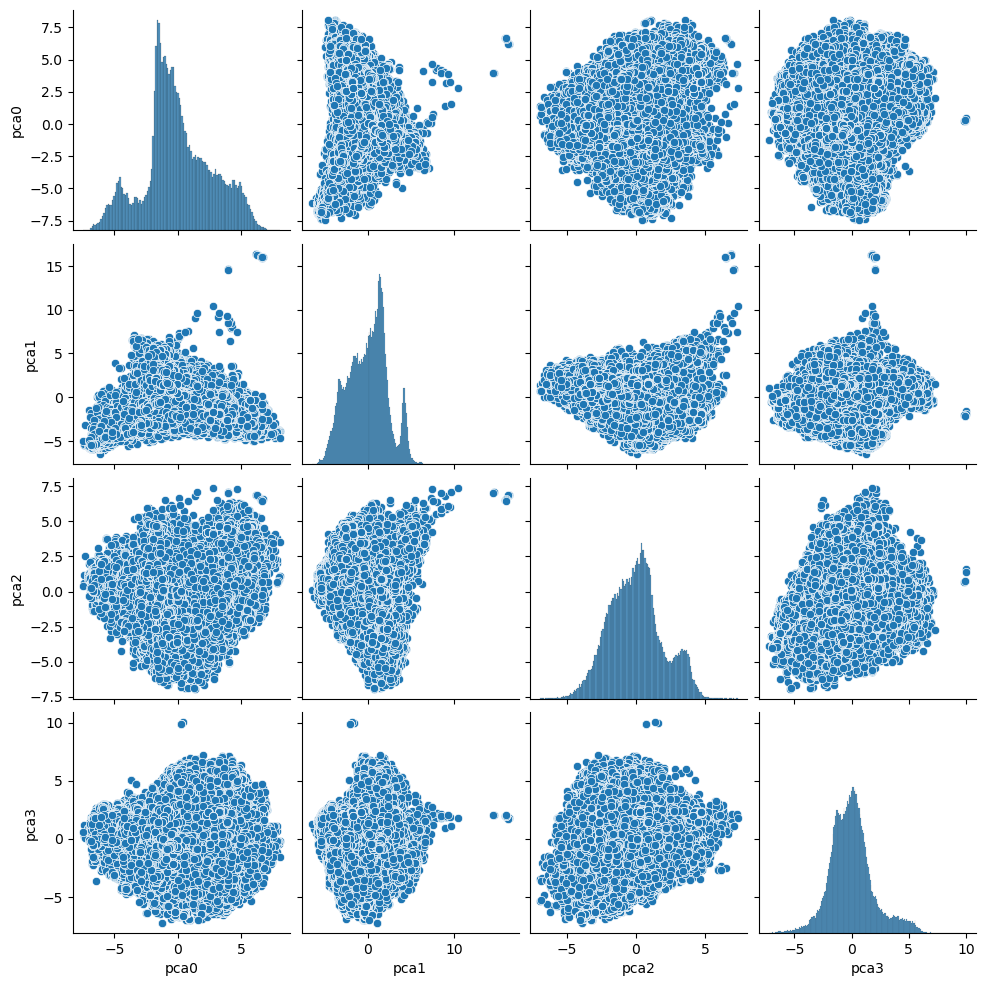

In [34]:
sns.pairplot(data=z_B_pca)